## Imports

In [142]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TunedThresholdClassifierCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import joblib

## DataFrames

In [48]:
df_train = pd.read_parquet("../data/SOT/base_tratada_treino_sem_outliers.parquet")
df_test = pd.read_parquet("../data/SOT/base_tratada_teste.parquet")
df_train.head()

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,...,VAR_54,VAR_57,VAR_59,VAR_65,VAR_66,VAR_67,VAR_72,VAR_74,VAR_76,VAR_77
0,1.0,201404,0,-0.727634,-0.306095,-0.342735,-0.482881,0.673819,0.278301,-0.213637,...,-0.809742,-0.064927,-0.943633,0.143174,-0.685373,0.142450,-0.014629,2.354360,-0.525657,-0.433522
1,2.0,201407,0,0.627340,-0.306095,2.017805,0.336321,-0.566411,0.150841,0.541208,...,0.175248,1.107199,-0.932521,0.284367,0.800071,0.198180,0.107461,-0.270421,-0.499363,0.272032
2,3.0,201405,0,1.368341,1.278230,2.017805,1.155524,-0.040989,0.056239,-0.798100,...,0.105216,-1.158910,0.066244,-0.246443,0.243029,0.209016,-0.201156,-0.270421,0.738035,1.160245
3,5.0,201403,1,-0.727634,-0.306095,-0.342735,-0.482881,-0.201561,-0.155736,-0.473936,...,0.796639,-0.611919,-0.224547,0.262330,-0.221172,-0.486060,-0.272375,-0.270421,-0.244562,-0.433522
4,6.0,201405,0,0.563826,-0.306095,4.378344,0.336321,-0.234582,-0.201127,-0.493764,...,-0.612744,-1.002627,-0.176851,-0.563487,-0.221172,0.209016,-0.509773,-0.270421,-0.226272,-0.433522


In [49]:
df_test.head()

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,...,VAR_54,VAR_57,VAR_59,VAR_65,VAR_66,VAR_67,VAR_72,VAR_74,VAR_76,VAR_77
0,13,201411,1,-0.727634,-0.306095,-0.342735,-0.482881,1.335696,-0.147789,-0.678210,...,-0.481412,-0.064927,0.031056,-0.311434,-0.128332,0.145546,0.046416,-0.270421,-0.153449,-0.433522
1,20,201411,0,-0.727634,-0.306095,-0.342735,-0.482881,-0.157372,0.001526,-0.251333,...,1.554235,0.638348,0.031056,-0.311434,-0.499693,0.114585,2.528917,-0.270421,-0.153449,-0.433522
2,32,201411,0,-0.537090,-0.306095,-0.342735,-0.482881,-0.008453,0.351812,-0.251333,...,-0.122948,-1.080769,0.636713,0.621421,0.057349,0.161027,-0.408031,0.604506,1.045672,0.200039
3,36,201411,1,0.309768,-0.306095,-0.342735,0.336321,-0.451647,-0.128991,0.166783,...,-0.087416,-0.377494,-0.639244,-0.224089,-0.128332,0.145546,-0.723430,2.354360,-0.389530,-0.433522
4,47,201411,0,-0.727634,-0.306095,-0.342735,-0.482881,-0.157372,-0.183704,-0.251333,...,-0.744076,1.419765,0.031056,1.076810,-0.128332,0.145546,0.334685,-0.270421,-0.153449,-0.433522


In [50]:
X_train = df_train.drop(columns=["id", "safra", "y"])
y_train = df_train["y"]
X_test = df_test.drop(columns=["id", "safra", "y"])
y_test = df_test["y"]

## Parâmetros

In [51]:
# RandomForest
rf_params = {
    'n_estimators': [50, 100],  
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Ridge 
ridge_params = {
    'alpha': [0.1, 1],
    'solver': ['auto', 'saga'], 
    'fit_intercept': [True]
}

# Logistic Regression 
logreg_params = {
    'C': [0.1, 1],
    'solver': ['lbfgs'],
    'max_iter': [100] 
}

# SVC
svc_params = {
    'C': [0.1, 1],
    'kernel': ['linear'],
    'gamma': ['scale']
}

# KNN
knn_params = {
    'n_neighbors': [3, 5],
    'weights': ['uniform'],
    'metric': ['euclidean']
}

# DecisionTree
dt_params = {
    'criterion': ['gini'],
    'max_depth': [10], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1], 
}

# AdaBoost 
ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'algorithm': ['SAMME']
}

# GradientBoosting 
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'max_depth': [3], 
    'min_samples_split': [2] 
}

# ExtraTree
et_params = {
    'n_estimators': [50, 100],
    'max_depth': [10], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1],
    'bootstrap': [True] 
}

In [52]:
clfs = {
    'RandomForest': RandomForestClassifier(random_state=98),
    'Ridge': RidgeClassifier(random_state=98),
    'LogisticRegression': LogisticRegression(random_state=98),
    'SVC': SVC(random_state=98),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=98),
    'AdaBoost': AdaBoostClassifier(random_state=98),
    'GradientBoosting': GradientBoostingClassifier(random_state=98),
    'ExtraTrees': ExtraTreesClassifier(random_state=98)
}

params = {
    'RandomForest': rf_params,
    'Ridge': ridge_params,
    'LogisticRegression': logreg_params,
    'SVC': svc_params,
    'KNN': knn_params,
    'DecisionTree': dt_params,
    'AdaBoost': ada_params,
    'GradientBoosting': gb_params,
    'ExtraTrees': et_params
}

### Classificadores sem balanceamento

In [53]:
def evaluate_classifiers(clfs, params, X_train, y_train, X_test, y_test, tune_threshold=False):
        rgsrs = {}
        results = {}

        for model in clfs.keys():
                gs = GridSearchCV(clfs[model], params[model], cv=5, scoring='f1_weighted', n_jobs=-1)
                gs.fit(X_train, y_train)
                print(f'{model} best params: {gs.best_params_}')
                if tune_threshold:
                        gs = TunedThresholdClassifierCV(gs, cv=5, scoring='f1_weighted', n_jobs=-1)
                        gs.fit(X_train, y_train)

                rgsrs[model] = gs
                results[model] = gs.best_score_
                print(f'{model} best score: {gs.best_score_}')

                y_pred = gs.predict(X_test)
                print(f'{model} accuracy: {accuracy_score(y_test, y_pred)}')
                print(f'{model} confusion matrix: {confusion_matrix(y_test, y_pred)}')
                print(f'{model} classification report:')
                print(f'{classification_report(y_test, y_pred)}')
                print('------------------------------------------------------------')
        
        return rgsrs, results

In [12]:
# Call the function
rgsrs, results = evaluate_classifiers(clfs, params, X_train, y_train, X_test, y_test)

RandomForest best score: 0.7895887860006082
RandomForest best params: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest accuracy: 0.6757425742574258
RandomForest confusion matrix: [[529  10]
 [252  17]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.68      0.98      0.80       539
           1       0.63      0.06      0.11       269

    accuracy                           0.68       808
   macro avg       0.65      0.52      0.46       808
weighted avg       0.66      0.68      0.57       808

------------------------------------------------------------
Ridge best score: 0.7839054318245146
Ridge best params: {'alpha': 1, 'fit_intercept': True, 'solver': 'saga'}
Ridge accuracy: 0.681930693069307
Ridge confusion matrix: [[524  15]
 [242  27]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.68      0

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost best score: 0.7614176858281264
AdaBoost best params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost accuracy: 0.6707920792079208
AdaBoost confusion matrix: [[532   7]
 [259  10]]
AdaBoost classification report:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       539
           1       0.59      0.04      0.07       269

    accuracy                           0.67       808
   macro avg       0.63      0.51      0.43       808
weighted avg       0.64      0.67      0.56       808

------------------------------------------------------------
GradientBoosting best score: 0.8025369499076607
GradientBoosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoosting accuracy: 0.6806930693069307
GradientBoosting confusion matrix: [[526  13]
 [245  24]]
GradientBoosting classification report:
              precision    recall  f1-score   support

   

### Com OverSampling por SMOTE

In [114]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(sampling_strategy='minority') 
X_train_sampled, y_train_sampled = smote.fit_resample(X_train,y_train)
y_train_sampled.value_counts()

y
0    6249
1    6249
Name: count, dtype: int64

In [115]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_sampled, y_train_sampled, X_test, y_test)

ExtraTrees best params: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
ExtraTrees best score: 0.743578808684535
ExtraTrees accuracy: 0.7066831683168316
ExtraTrees confusion matrix: [[437 102]
 [135 134]]
ExtraTrees classification report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       539
           1       0.57      0.50      0.53       269

    accuracy                           0.71       808
   macro avg       0.67      0.65      0.66       808
weighted avg       0.70      0.71      0.70       808

------------------------------------------------------------


### Tentando FEAT com ADASYN

In [55]:
from imblearn.over_sampling import ADASYN

# Applying ADASYN
adasyn = ADASYN(sampling_strategy='minority')
X_train_sampled, y_train_sampled = adasyn.fit_resample(X_train,y_train)
y_train_sampled.value_counts()

y
1    6489
0    6249
Name: count, dtype: int64

In [56]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_sampled, y_train_sampled, X_test, y_test)

RandomForest best params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest best score: 0.8524325643627524
RandomForest accuracy: 0.7042079207920792
RandomForest confusion matrix: [[481  58]
 [181  88]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       539
           1       0.60      0.33      0.42       269

    accuracy                           0.70       808
   macro avg       0.66      0.61      0.61       808
weighted avg       0.69      0.70      0.68       808

------------------------------------------------------------
Ridge best params: {'alpha': 1, 'fit_intercept': True, 'solver': 'saga'}
Ridge best score: 0.6878953975843491
Ridge accuracy: 0.698019801980198
Ridge confusion matrix: [[420 119]
 [125 144]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.77     

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost best params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost best score: 0.7137288506431813
AdaBoost accuracy: 0.6918316831683168
AdaBoost confusion matrix: [[441  98]
 [151 118]]
AdaBoost classification report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       539
           1       0.55      0.44      0.49       269

    accuracy                           0.69       808
   macro avg       0.65      0.63      0.63       808
weighted avg       0.68      0.69      0.68       808

------------------------------------------------------------
GradientBoosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoosting best score: 0.7975652544758873
GradientBoosting accuracy: 0.6881188118811881
GradientBoosting confusion matrix: [[468  71]
 [181  88]]
GradientBoosting classification report:
              precision    recall  f1-score   support

   

### Borderline SMOTE

In [17]:
from imblearn.over_sampling import BorderlineSMOTE

# Applying ADASYN
blsmote = BorderlineSMOTE(sampling_strategy='minority', kind='borderline-1')
X_train_sampled, y_train_sampled = blsmote.fit_resample(X_train,y_train)
y_train_sampled.value_counts()

y
0    6249
1    6249
Name: count, dtype: int64

In [18]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_sampled, y_train_sampled, X_test, y_test)

RandomForest best score: 0.9313598073338671
RandomForest best params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest accuracy: 0.6967821782178217
RandomForest confusion matrix: [[470  69]
 [176  93]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       539
           1       0.57      0.35      0.43       269

    accuracy                           0.70       808
   macro avg       0.65      0.61      0.61       808
weighted avg       0.68      0.70      0.67       808

------------------------------------------------------------
Ridge best score: 0.763205688160128
Ridge best params: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Ridge accuracy: 0.6955445544554455
Ridge confusion matrix: [[411 128]
 [118 151]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.78   

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost best score: 0.7735108667542034
AdaBoost best params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost accuracy: 0.6905940594059405
AdaBoost confusion matrix: [[422 117]
 [133 136]]
AdaBoost classification report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       539
           1       0.54      0.51      0.52       269

    accuracy                           0.69       808
   macro avg       0.65      0.64      0.65       808
weighted avg       0.69      0.69      0.69       808

------------------------------------------------------------
GradientBoosting best score: 0.8896749080800641
GradientBoosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoosting accuracy: 0.6967821782178217
GradientBoosting confusion matrix: [[471  68]
 [177  92]]
GradientBoosting classification report:
              precision    recall  f1-score   support

   

### Smote-ENN

In [19]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN()
X_train_sampled, y_train_sampled = smote_enn.fit_resample(X_train,y_train)
y_train_sampled.value_counts()

y
1    5051
0    2343
Name: count, dtype: int64

In [20]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_sampled, y_train_sampled, X_test, y_test)

RandomForest best score: 0.972185841472737
RandomForest best params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest accuracy: 0.6695544554455446
RandomForest confusion matrix: [[382 157]
 [110 159]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       539
           1       0.50      0.59      0.54       269

    accuracy                           0.67       808
   macro avg       0.64      0.65      0.64       808
weighted avg       0.69      0.67      0.68       808

------------------------------------------------------------
Ridge best score: 0.9057700540973199
Ridge best params: {'alpha': 1, 'fit_intercept': True, 'solver': 'saga'}
Ridge accuracy: 0.6349009900990099
Ridge confusion matrix: [[302 237]
 [ 58 211]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.84     

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost best score: 0.9107064693168357
AdaBoost best params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost accuracy: 0.594059405940594
AdaBoost confusion matrix: [[276 263]
 [ 65 204]]
AdaBoost classification report:
              precision    recall  f1-score   support

           0       0.81      0.51      0.63       539
           1       0.44      0.76      0.55       269

    accuracy                           0.59       808
   macro avg       0.62      0.64      0.59       808
weighted avg       0.69      0.59      0.60       808

------------------------------------------------------------
GradientBoosting best score: 0.9573007638476756
GradientBoosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoosting accuracy: 0.6584158415841584
GradientBoosting confusion matrix: [[341 198]
 [ 78 191]]
GradientBoosting classification report:
              precision    recall  f1-score   support

    

### Parâmetros com Class Weight

In [21]:
clfs = {
    'RandomForest': RandomForestClassifier(class_weight='balanced',random_state=98),
    'Ridge': RidgeClassifier(class_weight='balanced', random_state=98),
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=98),
    'SVC': SVC(class_weight='balanced', random_state=98),
    'DecisionTree': DecisionTreeClassifier(class_weight="balanced",random_state=98),
    # 'AdaBoost': AdaBoostClassifier(random_state=98),
    # 'GradientBoosting': GradientBoostingClassifier(random_state=98),
    'ExtraTrees': ExtraTreesClassifier(class_weight='balanced', random_state=98)
}


In [22]:
params = {
    'RandomForest': rf_params,
    'Ridge': ridge_params,
    'LogisticRegression': logreg_params,
    'SVC': svc_params,
    'DecisionTree': dt_params,
    # 'AdaBoost': ada_params,
    # 'GradientBoosting': gb_params,
    'ExtraTrees': et_params
}

In [23]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train, y_train, X_test, y_test)

RandomForest best score: 0.791079008614386
RandomForest best params: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest accuracy: 0.7128712871287128
RandomForest confusion matrix: [[504  35]
 [197  72]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.72      0.94      0.81       539
           1       0.67      0.27      0.38       269

    accuracy                           0.71       808
   macro avg       0.70      0.60      0.60       808
weighted avg       0.70      0.71      0.67       808

------------------------------------------------------------
Ridge best score: 0.7858027219857531
Ridge best params: {'alpha': 1, 'fit_intercept': True, 'solver': 'auto'}
Ridge accuracy: 0.7215346534653465
Ridge confusion matrix: [[460  79]
 [146 123]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.76      0

### Class Weight + SMOTE

In [24]:
smote = SMOTE(sampling_strategy=0.6, random_state=98) 
X_train_sampled, y_train_sampled = smote.fit_resample(X_train,y_train)
y_train_sampled.value_counts()

y
0    6249
1    3749
Name: count, dtype: int64

In [25]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_sampled, y_train_sampled, X_test, y_test)

RandomForest best score: 0.8657714388132419
RandomForest best params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest accuracy: 0.6868811881188119
RandomForest confusion matrix: [[519  20]
 [233  36]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       539
           1       0.64      0.13      0.22       269

    accuracy                           0.69       808
   macro avg       0.67      0.55      0.51       808
weighted avg       0.67      0.69      0.61       808

------------------------------------------------------------
Ridge best score: 0.7933723144907951
Ridge best params: {'alpha': 1, 'fit_intercept': True, 'solver': 'auto'}
Ridge accuracy: 0.7103960396039604
Ridge confusion matrix: [[452  87]
 [147 122]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.75    

### RAW Data + PCA

In [42]:
import sys
sys.path.append('../src')

from lib_aux import *

In [55]:
df = pd.read_csv("../data/SOR/base_modelo.csv")
df.head()

,id,safra,y,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,...,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78
0,1,201404,0,0.0,0.0,0.0,0.0,124.54,3277.0,51.98,...,156.38,7.52,0.0,151.0,0.0,3.0,477.84,173.06,0.00,3.0
1,2,201407,0,64.0,0.0,2.0,1.0,47.92,2443.0,84.72,...,707.84,NaN,NaN,187.0,NaN,NaN,NaN,184.69,54.00,NaN
2,3,201405,0,99.0,2.0,2.0,2.0,80.38,1824.0,26.63,...,471.86,NaN,NaN,96.0,NaN,NaN,NaN,732.00,121.98,NaN
3,4,201412,0,0.0,0.0,0.0,0.0,10.58,3796.0,NaN,...,119.96,23.00,0.0,417.0,0.0,0.0,NaN,NaN,0.00,0.0
4,5,201403,1,0.0,0.0,0.0,0.0,70.46,437.0,40.69,...,NaN,NaN,0.0,75.0,0.0,0.0,914.45,NaN,NaN,0.0


In [56]:
# Apply filtering
df_test = df[df["safra"] == 201411].copy(deep=True)
df_val = df[df["safra"] == 201412].copy(deep=True)
df = df[df["safra"] < 201411].reset_index(drop=True)

# Print final results
print("df_test shape:", df_test.shape)
print("df_val shape:", df_val.shape)
print("df shape:", df.shape)

df_test shape: (808, 81)
df_val shape: (786, 81)
df shape: (9144, 81)


In [58]:
df_train = df

In [59]:
df_train.drop(columns=['id', 'safra'], inplace=True)
df_test.drop(columns=['id', 'safra'], inplace=True)

In [64]:
na_count = (df_train.isna().sum() / len(df_train) * 100).sort_values(ascending=False)
na_count_critical = na_count[na_count >= 60]
df_train.drop(columns = na_count_critical.index, inplace=True)
df_test.drop(columns=na_count_critical.index, inplace=True)

In [66]:
df_train = fill_na_by(df_train, method = "median") ### Preenche os NA's
df_test = fill_na_by(df_test, method = "median") ### Preenche os NA's

In [68]:
X_train = df_train.drop(columns=["y"])
y_train = df_train["y"]
X_test = df_test.drop(columns=["y"])
y_test = df_test["y"]

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [70]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),          # Step 1: StandardScaler for normalization
    ('pca', PCA(n_components=0.95)),       # Step 2: PCA to retain 95% variance
    ('clf', LogisticRegression())         # Step 3: Logistic Regression classifier
])

In [71]:
# RandomForest
rf_params = {
    'clf__n_estimators': [50, 100],  
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__bootstrap': [True]
}

# Ridge 
ridge_params = {
    'clf__alpha': [0.1, 1],
    'clf__solver': ['auto', 'saga'], 
    'clf__fit_intercept': [True]
}

# Logistic Regression 
logreg_params = {
    'clf__C': [0.1, 1],
    'clf__solver': ['lbfgs'],
    'clf__max_iter': [100] 
}

# SVC
svc_params = {
    'clf__C': [0.1, 1],
    'clf__kernel': ['linear'],
    'clf__gamma': ['scale']
}

# KNN
knn_params = {
    'clf__n_neighbors': [3, 5],
    'clf__weights': ['uniform'],
    'clf__metric': ['euclidean']
}

# DecisionTree
dt_params = {
    'clf__criterion': ['gini'],
    'clf__max_depth': [10], 
    'clf__min_samples_split': [2], 
    'clf__min_samples_leaf': [1], 
}

# AdaBoost 
ada_params = {
    'clf__n_estimators': [50, 100],
    'clf__learning_rate': [0.1],
    'clf__algorithm': ['SAMME']
}

# GradientBoosting 
gb_params = {
    'clf__n_estimators': [50, 100],
    'clf__learning_rate': [0.1],
    'clf__max_depth': [3], 
    'clf__min_samples_split': [2] 
}

# ExtraTree
et_params = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [10], 
    'clf__min_samples_split': [2], 
    'clf__min_samples_leaf': [1],
    'clf__bootstrap': [True] 
}

params = {
    'RandomForest': rf_params,
    'Ridge': ridge_params,
    'LogisticRegression': logreg_params,
    'SVC': svc_params,
    'KNN': knn_params,
    'DecisionTree': dt_params,
    'AdaBoost': ada_params,
    'GradientBoosting': gb_params,
    'ExtraTrees': et_params
}

In [72]:
rgsrs = {}
results = {}

for model, clf in clfs.items():
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),          # Step 1: StandardScaler for normalization
        ('pca', PCA(n_components=0.95)),       # Step 2: PCA to retain 95% variance
        ('clf', clf)                           # Step 3: Classifier (this will change)
    ])
    
    # Step 4b: Set up GridSearchCV for each classifier with its respective parameters
    gs = GridSearchCV(pipeline, param_grid=params[model], cv=5, n_jobs=-1, scoring='roc_auc')

    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    rgsrs[model] = gs
    results[model] = gs.best_score_
    print(f'{model} best score: {gs.best_score_}')
    print(f'{model} best params: {gs.best_params_}')
    print(f'{model} accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'{model} confusion matrix: {confusion_matrix(y_test, y_pred)}')
    print(f'{model} classification report:')
    print(f'{classification_report(y_test, y_pred)}')
    print('------------------------------------------------------------')

RandomForest best score: 0.7661389890232708
RandomForest best params: {'clf__bootstrap': True, 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
RandomForest accuracy: 0.7116336633663366
RandomForest confusion matrix: [[487  52]
 [181  88]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       539
           1       0.63      0.33      0.43       269

    accuracy                           0.71       808
   macro avg       0.68      0.62      0.62       808
weighted avg       0.70      0.71      0.68       808

------------------------------------------------------------
Ridge best score: 0.7750761796494046
Ridge best params: {'clf__alpha': 1, 'clf__fit_intercept': True, 'clf__solver': 'saga'}
Ridge accuracy: 0.7091584158415841
Ridge confusion matrix: [[436 103]
 [132 137]]
Ridge classification report:
              precision    recall  f1-score 

# Dataframe com LOGs

In [ ]:
df_train = pd.read_parquet("../data/SOT/base_tratada_treino_LOG.parquet")
df_test = pd.read_parquet("../data/SOT/base_tratada_teste_LOG.parquet")
df_train.head()

,id,safra,y,VAR_2,VAR_3,VAR_4,VAR_9,VAR_14,VAR_17,VAR_19,...,log_VAR_65,log_VAR_15,log_VAR_35,log_VAR_52,log_VAR_5,log_VAR_38,log_VAR_24,log_VAR_45,log_VAR_1,log_VAR_59
0,1.0,201404,0,-0.306095,-0.342735,-0.482881,-0.979672,1.743720,0.520456,2.336353,...,0.533531,-1.062919,0.433640,-1.840272,0.971073,0.133697,0.809207,0.939938,-1.336531,-0.598788
1,2.0,201407,0,-0.306095,2.017805,0.336321,-0.220662,-0.263784,-0.190603,0.646951,...,0.632763,-0.134397,-0.273064,-0.090019,-0.582670,0.716001,0.245783,-0.076276,0.988031,-0.580202
2,3.0,201405,0,1.278230,2.017805,1.155524,1.135459,-0.283257,-0.125598,-0.354176,...,0.163875,0.707608,-1.691245,0.614341,0.254137,-0.552518,0.360154,0.018516,1.227918,0.328328
3,5.0,201403,1,-0.306095,-0.342735,-0.482881,1.297356,-0.862141,-0.279770,-0.479317,...,0.618105,-0.903285,0.580232,-0.386644,0.039806,0.666908,0.810336,0.073144,-1.336531,0.149738
4,6.0,201405,0,-0.306095,4.378344,0.336321,-1.131474,-0.283257,-0.125598,-0.479317,...,-0.379017,-0.051390,0.313698,0.044153,-0.007904,0.450513,0.095244,0.018516,0.961717,0.181798


In [75]:
df_test.head()

,id,safra,y,VAR_2,VAR_3,VAR_4,VAR_9,VAR_14,VAR_17,VAR_19,...,log_VAR_65,log_VAR_15,log_VAR_35,log_VAR_52,log_VAR_5,log_VAR_38,log_VAR_24,log_VAR_45,log_VAR_1,log_VAR_59
0,13,201411,1,-0.306095,-0.342735,-0.482881,-0.220662,-0.253162,-0.066866,-0.479317,...,0.079928,0.939818,-0.099179,0.912198,1.438752,0.145762,1.129604,0.118659,-1.336531,0.308656
1,20,201411,0,-0.306095,-0.342735,-0.482881,1.297356,0.196490,0.696653,-0.479317,...,0.079928,0.362980,-0.099179,0.437479,0.101585,-0.020108,0.047870,0.118659,-1.336531,0.308656
2,32,201411,0,-0.306095,-0.342735,-0.482881,-0.827870,0.600115,-0.889116,3.650333,...,0.827502,-0.542711,-1.690791,0.597780,0.294404,-0.020108,-1.109161,0.118659,-0.054306,0.595424
3,36,201411,1,-0.306095,-0.342735,0.336321,0.690149,-0.486840,1.460171,-0.479317,...,0.190728,0.362980,-0.099179,0.437479,-0.360801,0.426502,0.447838,0.835193,0.841930,-0.198353
4,47,201411,0,-0.306095,-0.342735,-0.482881,-0.827870,-0.253162,-0.654187,-0.479317,...,1.029933,1.913143,-0.099179,2.523441,0.101585,-0.020108,0.047870,0.118659,-1.336531,0.308656


### Parametros

In [76]:
# RandomForest
rf_params = {
    'n_estimators': [50, 100],  
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Ridge 
ridge_params = {
    'alpha': [0.1, 1],
    'solver': ['auto', 'saga'], 
    'fit_intercept': [True]
}

# Logistic Regression 
logreg_params = {
    'C': [0.1, 1],
    'solver': ['lbfgs'],
    'max_iter': [100] 
}

# SVC
svc_params = {
    'C': [0.1, 1],
    'kernel': ['linear'],
    'gamma': ['scale']
}

# KNN
knn_params = {
    'n_neighbors': [3, 5],
    'weights': ['uniform'],
    'metric': ['euclidean']
}

# DecisionTree
dt_params = {
    'criterion': ['gini'],
    'max_depth': [10], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1], 
}

# AdaBoost 
ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'algorithm': ['SAMME']
}

# GradientBoosting 
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'max_depth': [3], 
    'min_samples_split': [2] 
}

# ExtraTree
et_params = {
    'n_estimators': [50, 100],
    'max_depth': [10], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1],
    'bootstrap': [True] 
}

In [77]:
clfs = {
    'RandomForest': RandomForestClassifier(random_state=98),
    'Ridge': RidgeClassifier(random_state=98),
    'LogisticRegression': LogisticRegression(random_state=98),
    'SVC': SVC(random_state=98),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=98),
    'AdaBoost': AdaBoostClassifier(random_state=98),
    'GradientBoosting': GradientBoostingClassifier(random_state=98),
    'ExtraTrees': ExtraTreesClassifier(random_state=98)
}

params = {
    'RandomForest': rf_params,
    'Ridge': ridge_params,
    'LogisticRegression': logreg_params,
    'SVC': svc_params,
    'KNN': knn_params,
    'DecisionTree': dt_params,
    'AdaBoost': ada_params,
    'GradientBoosting': gb_params,
    'ExtraTrees': et_params
}

## Testes

In [78]:
X_train = df_train.drop(columns=["id", "safra", "y"])
y_train = df_train["y"]
X_test = df_test.drop(columns=["id", "safra", "y"])
y_test = df_test["y"]

### BorderlineSMOTE

In [80]:
blsmote = BorderlineSMOTE(sampling_strategy='minority', kind='borderline-1')
X_train_sampled, y_train_sampled = blsmote.fit_resample(X_train,y_train)
y_train_sampled.value_counts()

y
0    6453
1    6453
Name: count, dtype: int64

In [82]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_sampled, y_train_sampled, X_test, y_test)

RandomForest best score: 0.9311834479618823
RandomForest best params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest accuracy: 0.7054455445544554
RandomForest confusion matrix: [[467  72]
 [166 103]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       539
           1       0.59      0.38      0.46       269

    accuracy                           0.71       808
   macro avg       0.66      0.62      0.63       808
weighted avg       0.69      0.71      0.69       808

------------------------------------------------------------
Ridge best score: 0.7660266525428812
Ridge best params: {'alpha': 1, 'fit_intercept': True, 'solver': 'auto'}
Ridge accuracy: 0.6905940594059405
Ridge confusion matrix: [[410 129]
 [121 148]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.77    

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost best score: 0.7935652468272492
AdaBoost best params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost accuracy: 0.7029702970297029
AdaBoost confusion matrix: [[447  92]
 [148 121]]
AdaBoost classification report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       539
           1       0.57      0.45      0.50       269

    accuracy                           0.70       808
   macro avg       0.66      0.64      0.65       808
weighted avg       0.69      0.70      0.69       808

------------------------------------------------------------
GradientBoosting best score: 0.8939307309864113
GradientBoosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoosting accuracy: 0.693069306930693
GradientBoosting confusion matrix: [[481  58]
 [190  79]]
GradientBoosting classification report:
              precision    recall  f1-score   support

    

### Weigthed Classifiers

In [83]:
clfs = {
    'RandomForest': RandomForestClassifier(class_weight='balanced',random_state=98),
    'Ridge': RidgeClassifier(class_weight='balanced', random_state=98),
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=98),
    'SVC': SVC(class_weight='balanced', random_state=98),
    'DecisionTree': DecisionTreeClassifier(class_weight="balanced",random_state=98),
    # 'AdaBoost': AdaBoostClassifier(random_state=98),
    # 'GradientBoosting': GradientBoostingClassifier(random_state=98),
    'ExtraTrees': ExtraTreesClassifier(class_weight='balanced', random_state=98)
}
params = {
    'RandomForest': rf_params,
    'Ridge': ridge_params,
    'LogisticRegression': logreg_params,
    'SVC': svc_params,
    'DecisionTree': dt_params,
    # 'AdaBoost': ada_params,
    # 'GradientBoosting': gb_params,
    'ExtraTrees': et_params
}

In [84]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_sampled, y_train_sampled, X_test, y_test)

RandomForest best score: 0.9309485480285336
RandomForest best params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest accuracy: 0.7054455445544554
RandomForest confusion matrix: [[467  72]
 [166 103]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       539
           1       0.59      0.38      0.46       269

    accuracy                           0.71       808
   macro avg       0.66      0.62      0.63       808
weighted avg       0.69      0.71      0.69       808

------------------------------------------------------------
Ridge best score: 0.7660270130979198
Ridge best params: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Ridge accuracy: 0.6905940594059405
Ridge confusion matrix: [[410 129]
 [121 148]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.77  

### Tuning de Threshold do ExtraTree com Borderline

In [86]:
df_train = pd.read_parquet("../data/SOT/base_tratada_treino_sem_outliers.parquet")
df_test = pd.read_parquet("../data/SOT/base_tratada_teste.parquet")
X_train = df_train.drop(columns=["id", "safra", "y"])
y_train = df_train["y"]
X_test = df_test.drop(columns=["id", "safra", "y"])
y_test = df_test["y"]

In [88]:
blsmote = BorderlineSMOTE(sampling_strategy='minority', kind='borderline-1')
X_train_sampled, y_train_sampled = blsmote.fit_resample(X_train,y_train)
y_train_sampled.value_counts()

y
0    6249
1    6249
Name: count, dtype: int64

In [87]:
# ExtraTree
et_params = {
    'n_estimators': [50, 100],
    'max_depth': [10], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1],
    'bootstrap': [True] 
}

clfs = {
    'ExtraTrees': ExtraTreesClassifier(random_state=98)
}
params = {
    'ExtraTrees': et_params
}

In [89]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_sampled, y_train_sampled, X_test, y_test)

ExtraTrees best score: 0.8098742185300241
ExtraTrees best params: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
ExtraTrees accuracy: 0.6943069306930693
ExtraTrees confusion matrix: [[396 143]
 [104 165]]
ExtraTrees classification report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       539
           1       0.54      0.61      0.57       269

    accuracy                           0.69       808
   macro avg       0.66      0.67      0.67       808
weighted avg       0.71      0.69      0.70       808

------------------------------------------------------------


In [107]:
tuned_model = TunedThresholdClassifierCV(rgsrs["ExtraTrees"], cv=5, scoring='f1', store_cv_results=True, random_state=98)
tuned_model.fit(X_train_sampled, y_train_sampled)
avg_f1_train = tuned_model.best_score_
f1 = f1_score(y_test, tuned_model.predict(X_test))
print(f"Train F1: {avg_f1_train}")
print(f"Test F1: {f1}")
print(f"Threshold: {tuned_model.best_threshold_: .3f}")

confusion_matrix(y_test, tuned_model.predict(X_test))

Train F1: 0.7570601851237881
Test F1: 0.5636942675159236
Threshold:  0.469


array([[357, 182],
       [ 92, 177]])

In [108]:
print(classification_report(y_test, tuned_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72       539
           1       0.49      0.66      0.56       269

    accuracy                           0.66       808
   macro avg       0.64      0.66      0.64       808
weighted avg       0.69      0.66      0.67       808



### Sem inputação de Missings

In [44]:
df_train = pd.read_parquet("../data/SOT/base_tratada_com_na.parquet")
df_test = pd.read_parquet("../data/SOT/base_tratada_teste_com_na.parquet") 

In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier

# GradientBoosting
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'max_depth': [3], 
    'min_samples_split': [2] 
}

# HistGradientBoosting

hgb_params = {
    'max_iter': [50, 100],
    'max_depth': [3], 
    'min_samples_leaf': [1],
    'l2_regularization': [0.0, 0.1],
    'learning_rate': [0.1]
}




clfs = {
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=98, class_weight='balanced')
}

params = {
    'HistGradientBoosting': hgb_params
}

X_train = df_train.drop(columns=["id", "safra", "y"])
y_train = df_train["y"]

X_test = df_test.drop(columns=["id", "safra", "y"])
y_test = df_test["y"]

rgsrs, results = evaluate_classifiers(clfs, params, X_train, y_train, X_test, y_test)


HistGradientBoosting best params: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100, 'min_samples_leaf': 1}
HistGradientBoosting best score: 0.738073802129549
HistGradientBoosting accuracy: 0.6806930693069307
HistGradientBoosting confusion matrix: [[505  34]
 [224  45]]
HistGradientBoosting classification report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.80       539
           1       0.57      0.17      0.26       269

    accuracy                           0.68       808
   macro avg       0.63      0.55      0.53       808
weighted avg       0.65      0.68      0.62       808

------------------------------------------------------------


### Inputação de missings com MICE

In [46]:
from fancyimpute import IterativeImputer

imputador = IterativeImputer()

df_train = pd.read_parquet("../data/SOT/base_tratada_com_na.parquet")
df_test = pd.read_parquet("../data/SOT/base_tratada_teste_com_na.parquet")

X_train = df_train.drop(columns=["id", "safra", "y"])
X_train = imputador.fit_transform(X_train)
y_train = df_train["y"]

X_test = df_test.drop(columns=["id", "safra", "y"])
X_test = imputador.transform(X_test)
y_test = df_test["y"]

# RandomForest
rf_params = {
    'n_estimators': [50, 100],  
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Ridge 
ridge_params = {
    'alpha': [0.1, 1],
    'solver': ['auto', 'saga'], 
    'fit_intercept': [True]
}

# Logistic Regression 
logreg_params = {
    'C': [0.1, 1],
    'solver': ['lbfgs'],
    'max_iter': [100] 
}

# SVC
svc_params = {
    'C': [0.1, 1],
    'kernel': ['linear'],
    'gamma': ['scale']
}

# KNN
knn_params = {
    'n_neighbors': [3, 5],
    'weights': ['uniform'],
    'metric': ['euclidean']
}

# DecisionTree
dt_params = {
    'criterion': ['gini'],
    'max_depth': [10], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1], 
}

# AdaBoost 
ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'algorithm': ['SAMME']
}

# GradientBoosting 
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'max_depth': [3], 
    'min_samples_split': [2] 
}

# ExtraTree
et_params = {
    'n_estimators': [50, 100],
    'max_depth': [10], 
    'min_samples_split': [2], 
    'min_samples_leaf': [1],
    'bootstrap': [True] 
}

clfs = {
    'RandomForest': RandomForestClassifier(random_state=98),
    'Ridge': RidgeClassifier(random_state=98),
    'LogisticRegression': LogisticRegression(random_state=98),
    'SVC': SVC(random_state=98),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=98),
    'AdaBoost': AdaBoostClassifier(random_state=98),
    'GradientBoosting': GradientBoostingClassifier(random_state=98),
    'ExtraTrees': ExtraTreesClassifier(random_state=98)
}

params = {
    'RandomForest': rf_params,
    'Ridge': ridge_params,
    'LogisticRegression': logreg_params,
    'SVC': svc_params,
    'KNN': knn_params,
    'DecisionTree': dt_params,
    'AdaBoost': ada_params,
    'GradientBoosting': gb_params,
    'ExtraTrees': et_params
}

rgsrs, results = evaluate_classifiers(clfs, params, X_train, y_train, X_test, y_test)

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


RandomForest best params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
RandomForest best score: 0.7534887038068568
RandomForest accuracy: 0.5185643564356436
RandomForest confusion matrix: [[275 264]
 [125 144]]
RandomForest classification report:
              precision    recall  f1-score   support

           0       0.69      0.51      0.59       539
           1       0.35      0.54      0.43       269

    accuracy                           0.52       808
   macro avg       0.52      0.52      0.51       808
weighted avg       0.58      0.52      0.53       808

------------------------------------------------------------
Ridge best params: {'alpha': 1, 'fit_intercept': True, 'solver': 'auto'}
Ridge best score: 0.7499005901768707
Ridge accuracy: 0.650990099009901
Ridge confusion matrix: [[342 197]
 [ 85 184]]
Ridge classification report:
              precision    recall  f1-score   support

           0       0.80      

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost best params: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost best score: 0.722057976026613
AdaBoost accuracy: 0.5037128712871287
AdaBoost confusion matrix: [[230 309]
 [ 92 177]]
AdaBoost classification report:
              precision    recall  f1-score   support

           0       0.71      0.43      0.53       539
           1       0.36      0.66      0.47       269

    accuracy                           0.50       808
   macro avg       0.54      0.54      0.50       808
weighted avg       0.60      0.50      0.51       808

------------------------------------------------------------
GradientBoosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoosting best score: 0.7555835469138963
GradientBoosting accuracy: 0.3353960396039604
GradientBoosting confusion matrix: [[  2 537]
 [  0 269]]
GradientBoosting classification report:
              precision    recall  f1-score   support

    

In [41]:
df_test = fill_na_by(df_test, method = "median") ### Preenche os NA's
df_train = fill_na_by(df_train, "safra", method='median')

c:\Users\Leonardo\credit-code-challenge\notebooks\../src\lib_aux.py:176: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5063.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[coluna_alvo].isna() & (df[column] == grouped_var), coluna_alvo] = grouped_df.loc[grouped_var, (coluna_alvo, method)]


### Tunando o melhor modelo

Ao que tudo indica, o melhor modelo foi a regressão logistica utilizando ADASYN sampling, portanto, vamos tentar refinar este modelo

In [102]:
df_train = pd.read_parquet("../data/SOT/base_tratada_treino_sem_outliers.parquet")
df_test = pd.read_parquet("../data/SOT/base_tratada_teste.parquet")

X_train = df_train.drop(columns=["id", "safra", "y"])
y_train = df_train["y"]
X_test = df_test.drop(columns=["id", "safra", "y"])
y_test = df_test["y"]

#### Parâmetros

In [76]:
# Logistic Regression (more parameters)
logreg_params = {

    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200],
    'penalty': ["l1","l2", None]
}


clfs = {
    'LogisticRegression': LogisticRegression(random_state=98)
}

params = {
    'LogisticRegression': logreg_params,
}

#### Tentativa de PCA

In [80]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train)
X_train_pca

X_test_pca = pca.transform(X_test)

In [78]:
rgsrs, results = evaluate_classifiers(clfs, params, X_train_pca, y_train, X_test_pca, y_test)

LogisticRegression best params: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression best score: 0.7420510734157503
LogisticRegression accuracy: 0.6893564356435643
LogisticRegression confusion matrix: [[524  15]
 [236  33]]
LogisticRegression classification report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81       539
           1       0.69      0.12      0.21       269

    accuracy                           0.69       808
   macro avg       0.69      0.55      0.51       808
weighted avg       0.69      0.69      0.61       808

------------------------------------------------------------


c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Leonardo

In [ ]:
adasyn = ADASYN(sampling_strategy='minority', random_state=98)
X_train_res, y_train_res = adasyn.fit_resample(X_train_pca, y_train)
X_train_res_puro, y_train_res_puro = adasyn.fit_resample(X_train, y_train)

rgsrs, results = evaluate_classifiers(clfs, params, X_train_res, y_train_res, X_test_pca, y_test)
print("----------------------------------------- PURO")
rgsrs_puro, results_puro = evaluate_classifiers(clfs, params, X_train_res_puro, y_train_res_puro, X_test, y_test)

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Leonardo

LogisticRegression best params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression best score: 0.673546404388218
LogisticRegression accuracy: 0.7042079207920792
LogisticRegression confusion matrix: [[399 140]
 [ 99 170]]
LogisticRegression classification report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       539
           1       0.55      0.63      0.59       269

    accuracy                           0.70       808
   macro avg       0.67      0.69      0.68       808
weighted avg       0.72      0.70      0.71       808

------------------------------------------------------------
----------------------------------------- PURO
LogisticRegression best params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression best score: 0.6873782706960833
LogisticRegression accuracy: 0.7029702970297029
LogisticRegression confusion matrix: [[422 117]
 [123 146]]
LogisticRegr

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Leonardo

In [86]:
#### Tentando o ThreshHold Optimizer 

rgsrs_opt, results_opt = evaluate_classifiers(clfs, params, X_train_res, y_train_res, X_test_pca, y_test, True) ### Ainda fica pior

LogisticRegression best params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression best score: 0.6730880156804665
LogisticRegression accuracy: 0.6782178217821783
LogisticRegression confusion matrix: [[373 166]
 [ 94 175]]
LogisticRegression classification report:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       539
           1       0.51      0.65      0.57       269

    accuracy                           0.68       808
   macro avg       0.66      0.67      0.66       808
weighted avg       0.70      0.68      0.69       808

------------------------------------------------------------


In [84]:
# Logistic Regression (more parameters)
logreg_params = {

    'C': [0.1],
    'solver': ['liblinear'],
    'max_iter': [100],
    'penalty': ["l2"]
}


clfs = {
    'LogisticRegression': LogisticRegression(random_state=98)
}

params = {
    'LogisticRegression': logreg_params,
}

In [85]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train_res)
X_poly_test = poly.transform(X_test_pca)

rgsrs_poly, results_poly = evaluate_classifiers(clfs, params, X_poly, y_train_res, X_poly_test, y_test)

LogisticRegression best params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression best score: 0.7020734096834057
LogisticRegression accuracy: 0.6707920792079208
LogisticRegression confusion matrix: [[376 163]
 [103 166]]
LogisticRegression classification report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       539
           1       0.50      0.62      0.56       269

    accuracy                           0.67       808
   macro avg       0.64      0.66      0.65       808
weighted avg       0.69      0.67      0.68       808

------------------------------------------------------------


In [154]:
### Salvando o modelo de treino

joblib.dump(rgsrs["LogisticRegression"], "../models/logistic_regression_train_step.pkl")

['../models/logistic_regression_train_step.pkl']

### Conjunto de Validação

In [113]:
#### Assumindo o melhor modelo como o de melhores metricas, vamos testar no conjunto de validação

df_val = pd.read_parquet("../data/SOT/base_validacao_nao_normalizada.parquet")

X_val = df_val.drop(columns=["id", "safra", "y"])
y_val = df_val["y"]

In [114]:
rgsrs["LogisticRegression"].best_params_

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [115]:
model = LogisticRegression(**rgsrs["LogisticRegression"].best_params_, random_state=98)

In [153]:
rgsrs["LogisticRegression"].best_params_

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [119]:
scaler = joblib.load("../artifacts/scaler.pkl")

X_total = pd.concat([X_train, X_test])
X_total = scaler.inverse_transform(X_total)
y_total = pd.concat([y_train, y_test])

In [131]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),          
    ('pca', PCA(n_components=0.95))
])

X_train_total = pipeline.fit_transform(X_total)
X_val_total = pipeline.transform(X_val)

X_train_final, y_train_final = adasyn.fit_resample(X_train_total, y_total)

model.fit(X_train_final, y_train_final)

c:\Users\Leonardo\anaconda3\envs\credit-score-challenge\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


LogisticRegression(C=0.1, random_state=98, solver='liblinear')

In [141]:
y_pred_val = model.predict(X_val_total)
print(f'accuracy: {accuracy_score(y_val, y_pred_val)}')
print(f'confusion matrix: {confusion_matrix(y_val, y_pred_val)}')
print(f'classification report:')
print(f'{classification_report(y_val, y_pred_val)}')

accuracy: 0.6513994910941476
confusion matrix: [[346 163]
 [111 166]]
classification report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       509
           1       0.50      0.60      0.55       277

    accuracy                           0.65       786
   macro avg       0.63      0.64      0.63       786
weighted avg       0.67      0.65      0.66       786



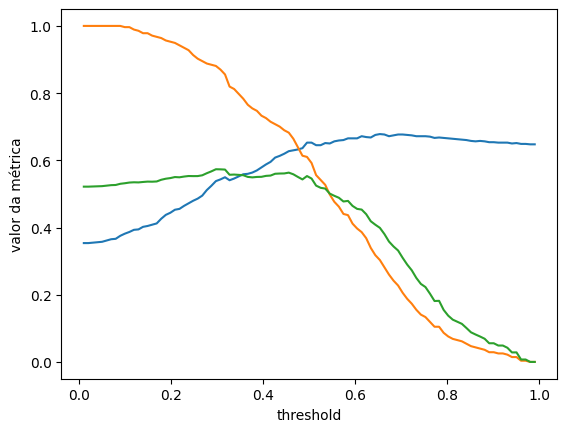

In [152]:
### Vendo resultados

threshold_v = np.linspace(0.01, 0.99, 100)
acc_v = []
prec_v = []
recall_v = []
f1_v = []

for threshold in threshold_v:
    y_pred = model.predict_proba(X_val_total)[:,1] > threshold

    acc_v.append(accuracy_score(y_val, y_pred))
    recall_v.append(recall_score(y_val, y_pred))
    f1_v.append(f1_score(y_val, y_pred))
    
plt.plot(threshold_v, acc_v, label='accuracy')
plt.plot(threshold_v, recall_v, label='recall')
plt.plot(threshold_v, f1_v, label='f1')
plt.xlabel('threshold')
plt.ylabel('valor da métrica')
plt.savefig("../graficos/linha_metricas.png")

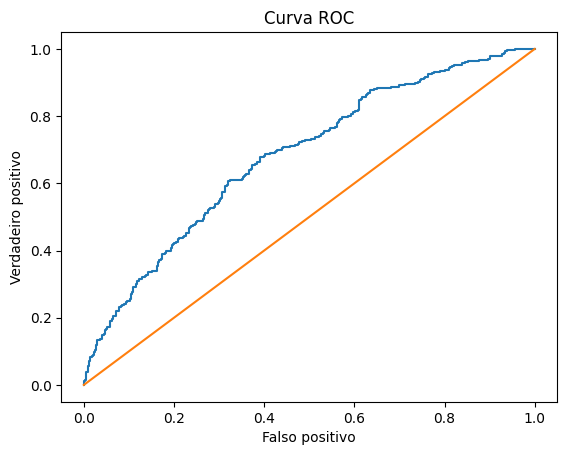

In [151]:
fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val_total)[:,1])
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.xlabel('Falso positivo')
plt.ylabel('Verdadeiro positivo')
plt.title('Curva ROC')
plt.savefig("../graficos/curva_roc.png")

In [145]:
print("AUC: ",auc(fpr, tpr))

AUC:  0.6808068485669501


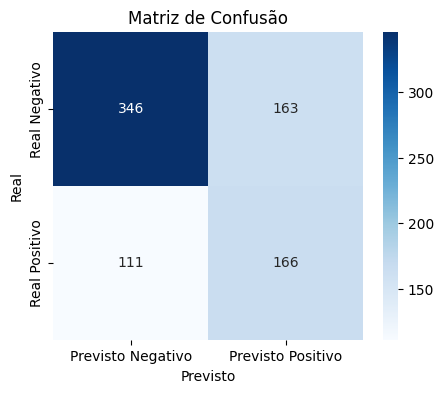

In [150]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto Negativo', 'Previsto Positivo'], yticklabels=['Real Negativo', 'Real Positivo'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.savefig("../graficos/confusion_matrix.png")
plt.show()